# Audio Processor
Convert audio file into metrics

- [Pitch](#pitch)
- [Intensity](#intensity)
- [Speech Tempo](#speech-tempo)

In [1]:
import parselmouth
import numpy as np
import uuid
import pandas as pd
import os
import shutil
import matplotlib.pyplot as plt
import seaborn as sns
import matplotlib.patches as mpatches
import librosa

## Select audio file to analyze

In [2]:
audio_filename = "/workspaces/voice-analysis/data/01_raw/joseph_elrion.wav"
audio_filename_language = "es"

#audio_filename = "/workspaces/voice-analysis/data/01_raw/high.wav"
#audio_filename_language = "en"


### Some Useful functions

In [3]:
def generate_analysis_id(audio_filename: str) -> str:
    # Create new recording_id
    return str(uuid.uuid4().hex)

def get_destination_folder(analysis_id: str, audio_filename: str) -> str:
    # Destination Paths folder, processed wav and csv
    base_name, extension = os.path.splitext(os.path.basename(audio_filename))
    return f"/workspaces/voice-analysis/data/02_processed/{analysis_id}__{base_name}{extension}/"

def get_destination_audio_filename(analysis_id: str, audio_filename: str) -> str:
    base_name, extension = os.path.splitext(os.path.basename(audio_filename))
    destination_folder = get_destination_folder(analysis_id, audio_filename)
    return os.path.join(destination_folder, f"{analysis_id}__{base_name}{extension}")

def get_destination_analysis_filename(analysis_id: str, audio_filename: str, analysis_type: str, analysis_filename_extension: str = "csv") -> str:
    base_name, extension = os.path.splitext(os.path.basename(audio_filename))
    destination_folder = get_destination_folder(analysis_id, audio_filename)
    return os.path.join(destination_folder, f"{analysis_id}__{base_name}{extension}_{analysis_type}.{analysis_filename_extension}")

In [4]:
# Vocal Categories ranges 
categories = {
    'Soprano': {'range': [261.63, 1046.50], 'color': 'grey'},
    'Mezzo-Soprano': {'range': [220.00, 880.00], 'color': 'yellow'},
    'Alto': {'range': [174.61, 698.46], 'color': 'cyan'},
    'Tenor': {'range': [130.81, 523.25], 'color': 'green'},
    'Baritone': {'range': [98.00, 392.00], 'color': 'blue'},
    'Bass': {'range': [82.41, 329.63], 'color': 'red'}
}

def draw_horizontal_shadows(plt, transparency):    
    for  category_name, v in categories.items():
        plt.axhspan(v["range"][0], v["range"][1], facecolor = v["color"], alpha = transparency)            

def draw_legend(plt, transparency):    
    handle_values = []
    for  category_name, v in categories.items():        
        handle_values.append(mpatches.Patch(color=v["color"], alpha=transparency, label= f'{category_name}-{v["range"]}' ))
    plt.legend(handles= handle_values, loc='upper left', bbox_to_anchor=(1, 1))

## Pitch
Extracts frequency (Hz) of sound over a time series (seconds) 

###  Persist Pitch Metrics

In [5]:
# Process audio 
snd = parselmouth.Sound(audio_filename)
# Extract Pitch timeseries
pitch = snd.to_pitch()
# Extract time & frequency to persist
dfPitch = pd.DataFrame(data=zip(pitch.xs(), pitch.selected_array['frequency']), columns=["time", "frequency"])

# Create new analysis_id
analysis_id = generate_analysis_id(audio_filename)
destination_folder = get_destination_folder(analysis_id, audio_filename)
destination_audio_filename = get_destination_audio_filename(analysis_id, audio_filename)
destination_pitch_csv =  get_destination_analysis_filename(analysis_id, audio_filename, "pitch")

# Create/ensure the folder
os.makedirs(destination_folder, exist_ok=True)

# Move the wav file to the new folder and rename it
shutil.copy(audio_filename, destination_audio_filename)

# Save data
dfPitch.to_csv(destination_pitch_csv, index=False)

### Plot Pitch Metrics

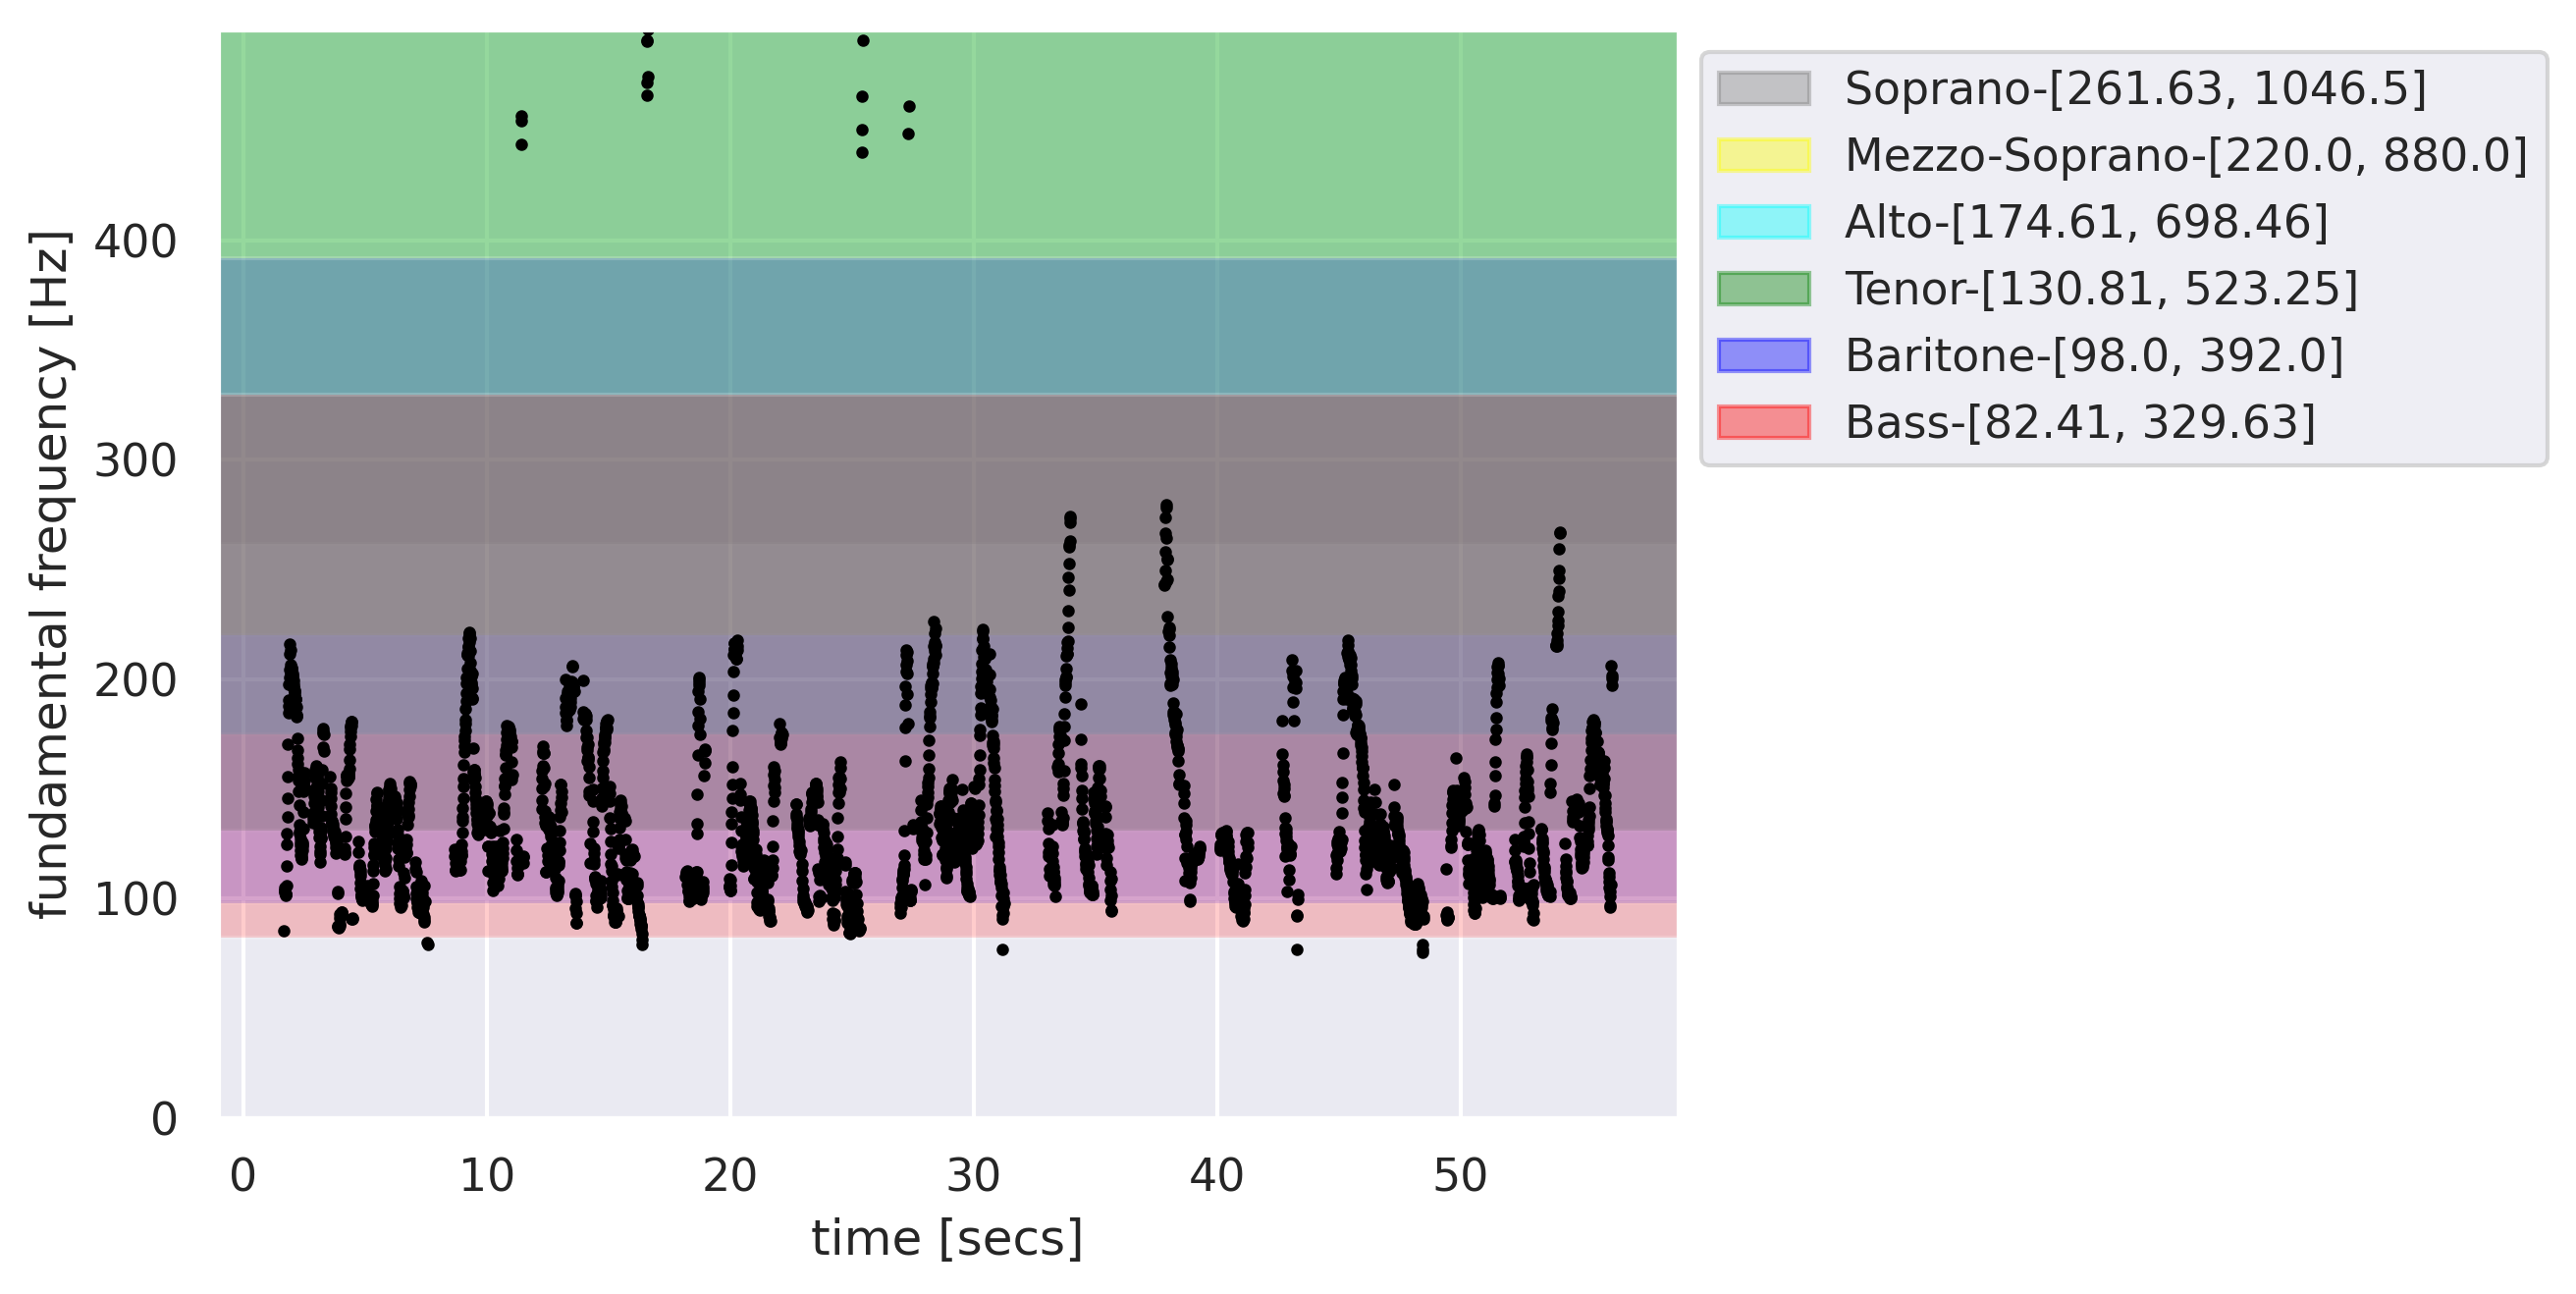

In [6]:
plt.rcParams['figure.dpi'] = 300
sns.set_theme()

pitch_values = pitch.selected_array['frequency']
# NOt plotting zero values
pitch_values[pitch_values==0] = np.nan    
plt.plot(pitch.xs(), pitch_values, '.', markersize=4, color="black")            
plt.ylim(0, np.nanmax(pitch_values))  

plt.ylabel("fundamental frequency [Hz]")
plt.xlabel("time [secs]")

draw_horizontal_shadows(plt, 0.2)
draw_legend(plt, 0.4)

plt.show() 

### Plot Vocal Categories for Reference

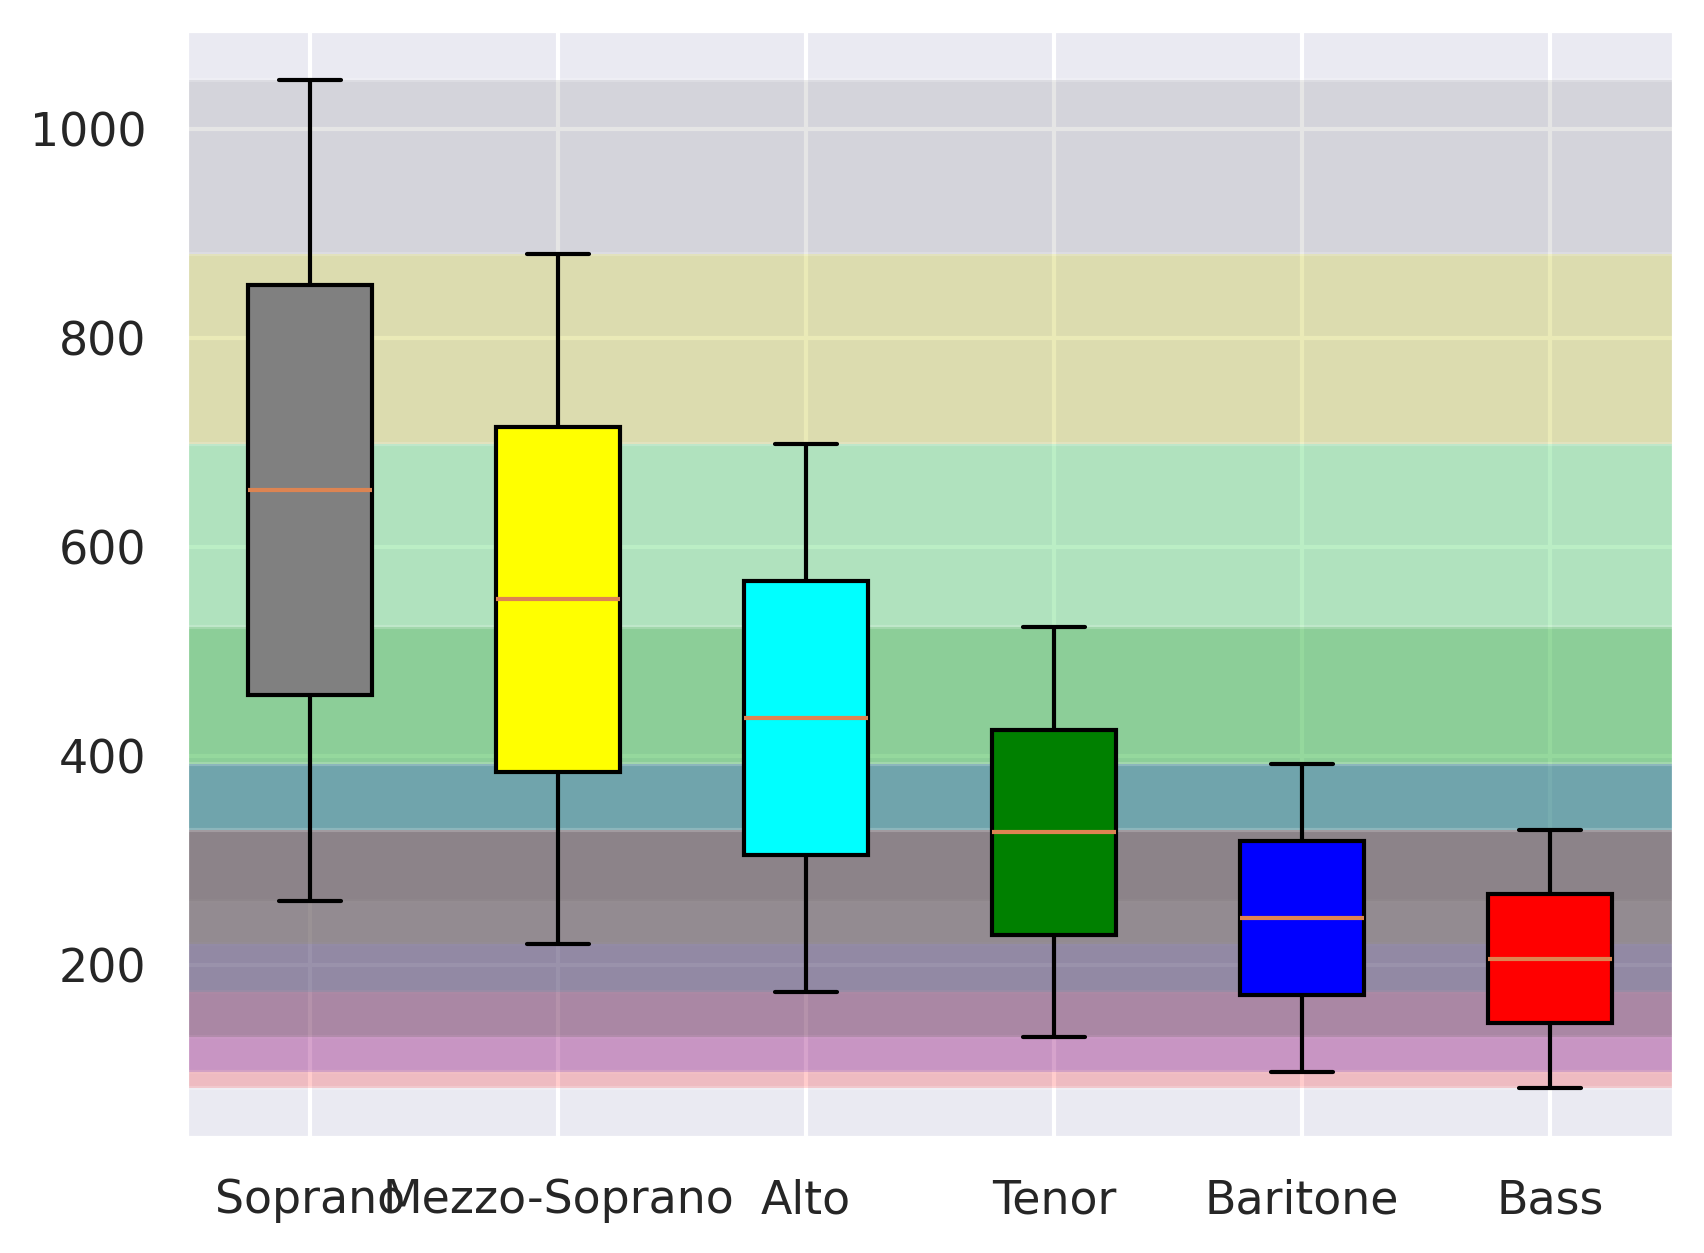

In [7]:

draw_horizontal_shadows(plt, 0.2)
#draw_legend(plt, 0.4)
box = plt.boxplot([v["range"] for v in categories.values()], patch_artist=True, tick_labels=categories.keys())
# Set the colors for each box
for patch, color in zip(box['boxes'], [v["color"] for v in categories.values()]):
    patch.set_facecolor(color)
    patch.set_alpha(1)

plt.show()

## Intensity
Extracts intensity or amplitude (dB) of sound over a time series (seconds) 


### Persist Intensity Metrics

In [8]:


# snd SOund object already had calculated the amplitude timeseries
dfAmplitude = pd.DataFrame(data=zip(snd.xs(), snd.values[0], snd.values[1]), columns=["time", "amplitude_left_channel", "amplitude_right_channel"])
destination_amplitude_csv =  get_destination_analysis_filename(analysis_id, audio_filename, "amplitude")
# Save csvs
#dfAmplitude.to_csv(destination_amplitude_csv, index=False)
destination_amplitude_parquet =  get_destination_analysis_filename(analysis_id, audio_filename, "amplitude", "parquet")
dfAmplitude.to_parquet(destination_amplitude_parquet, index=False)


# Extract intensity timeseries
intensity = snd.to_intensity()
dfIntensity = pd.DataFrame(data=zip(intensity.xs(), intensity.values.T), columns=["time", "intensity"])
destination_intensity_csv =  get_destination_analysis_filename(analysis_id, audio_filename, "intensity")
# Save csvs
dfIntensity.to_csv(destination_intensity_csv, index=False)



/usr/local/python/3.10.15/lib/python3.10/site-packages/IPython/core/pylabtools.py:170: UserWarning: Creating legend with loc="best" can be slow with large amounts of data.
  fig.canvas.print_figure(bytes_io, **kw)


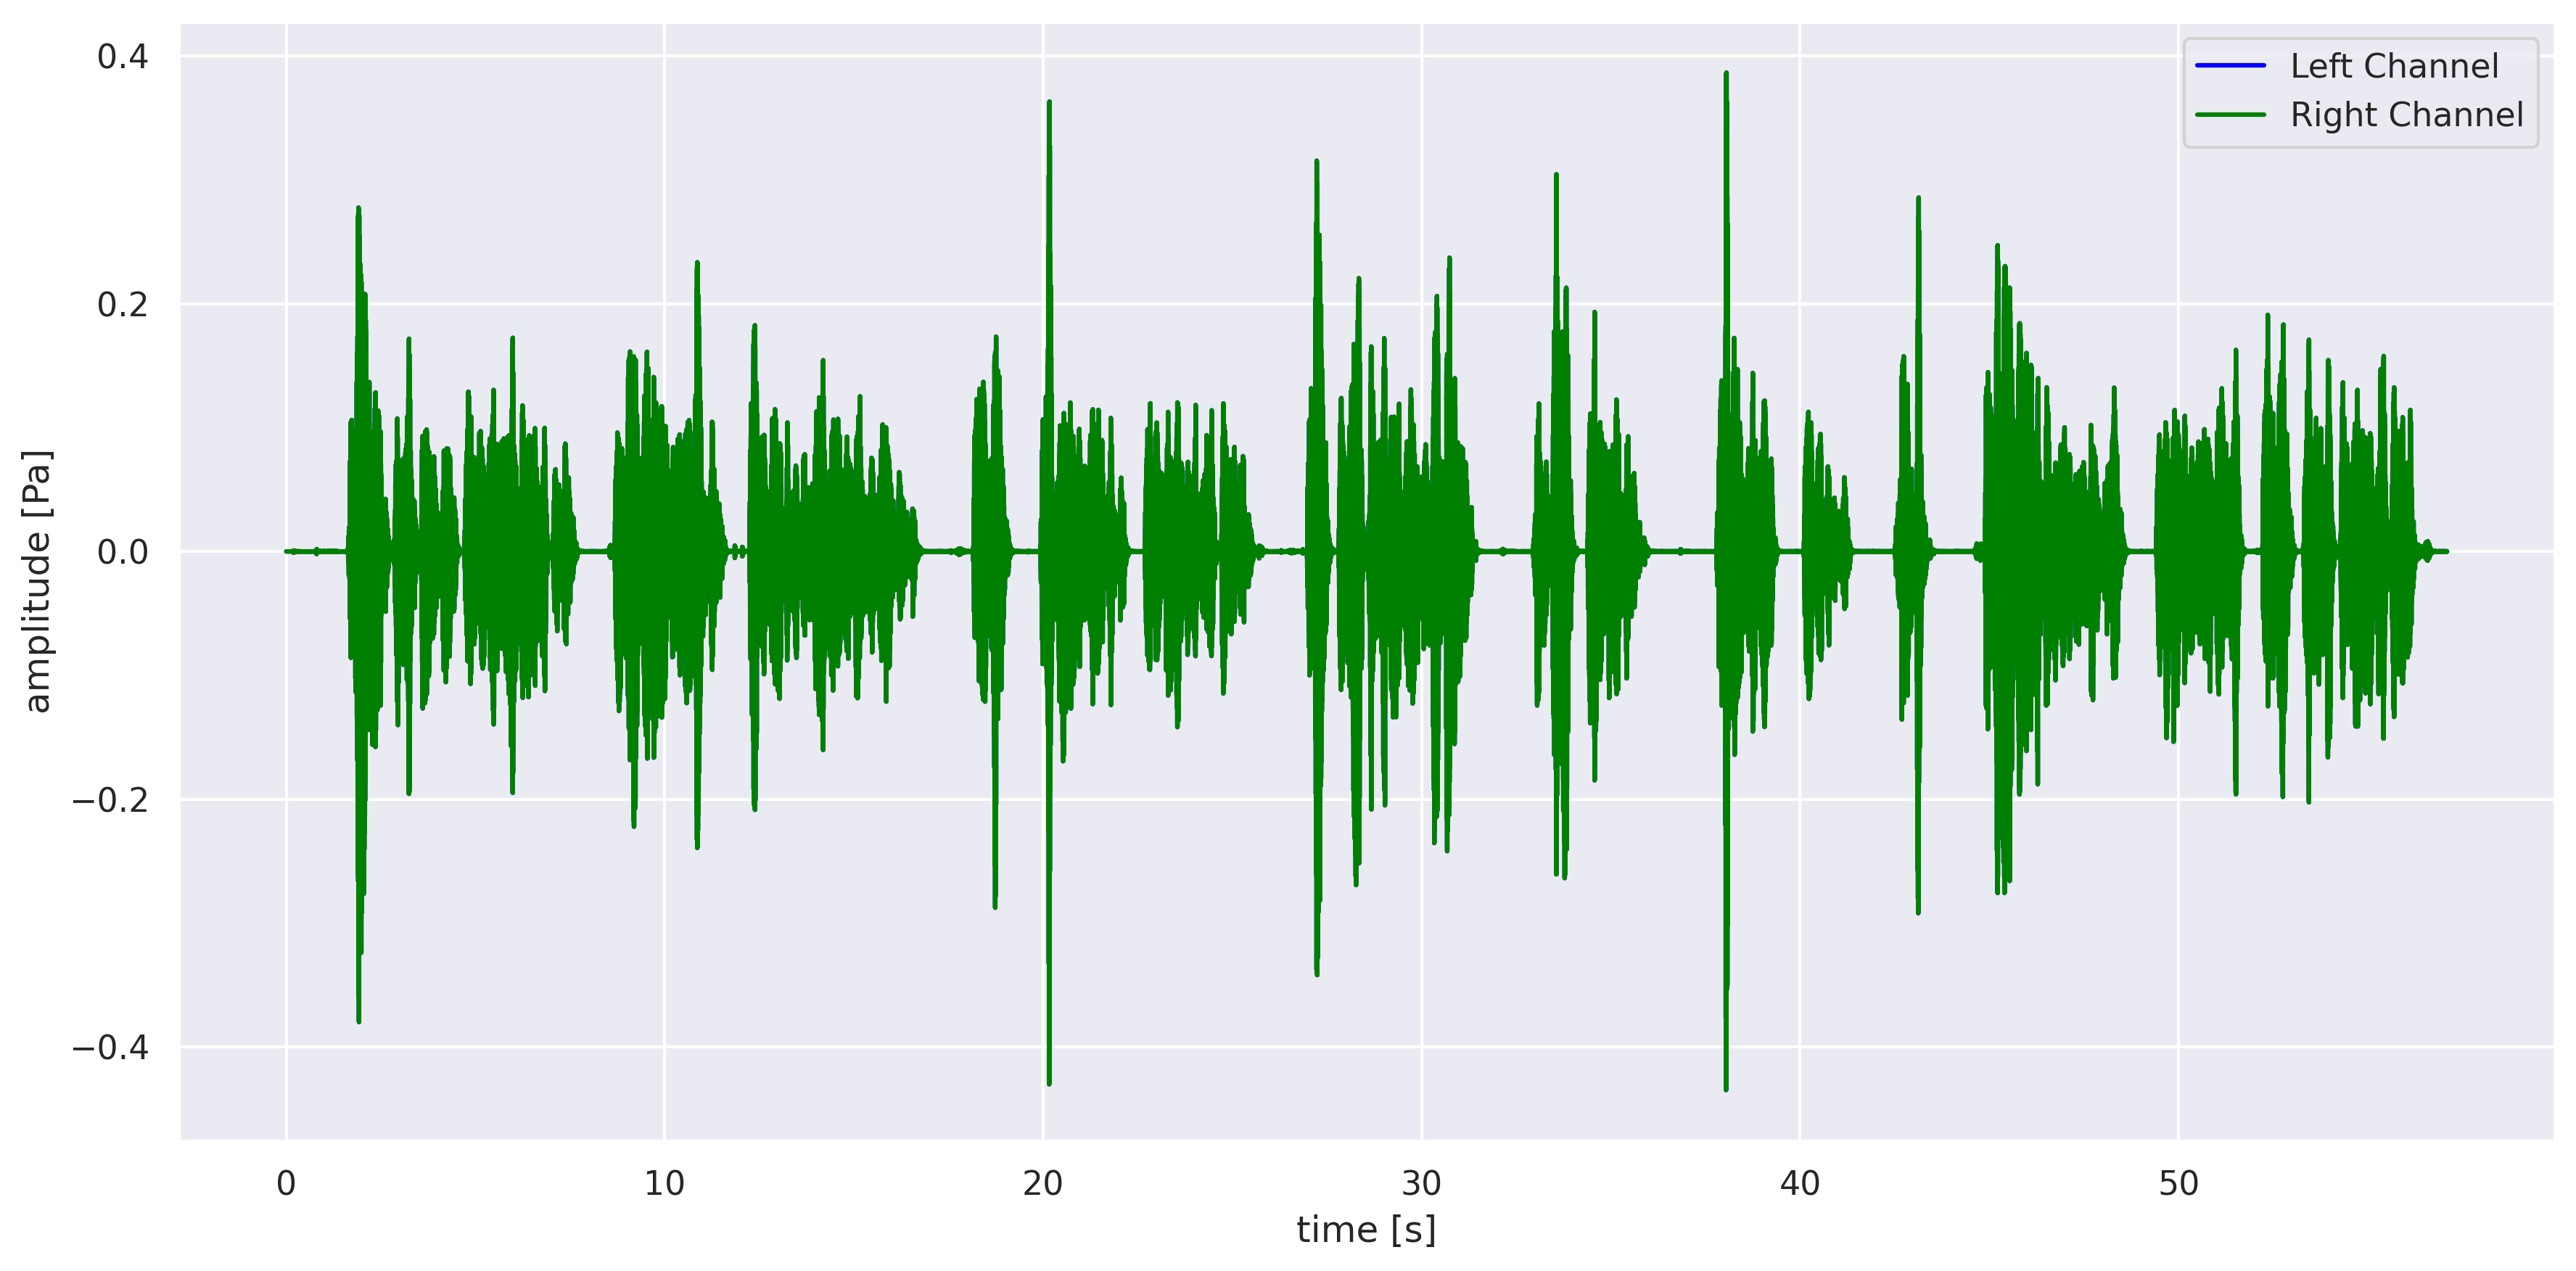

In [9]:


fig, ax1 = plt.subplots(figsize=(12, 6)) 
# Plot the left channel
ax1.plot(snd.xs(), snd.values[0], color='blue', label='Left Channel')

# Plot the right channel
ax1.plot(snd.xs(), snd.values[1], color='green', label='Right Channel')

ax1.set_xlabel("time [s]")
ax1.set_ylabel("amplitude [Pa]")
ax1.legend()
fig.tight_layout()  # Adjust layout to prevent overlap

plt.show()

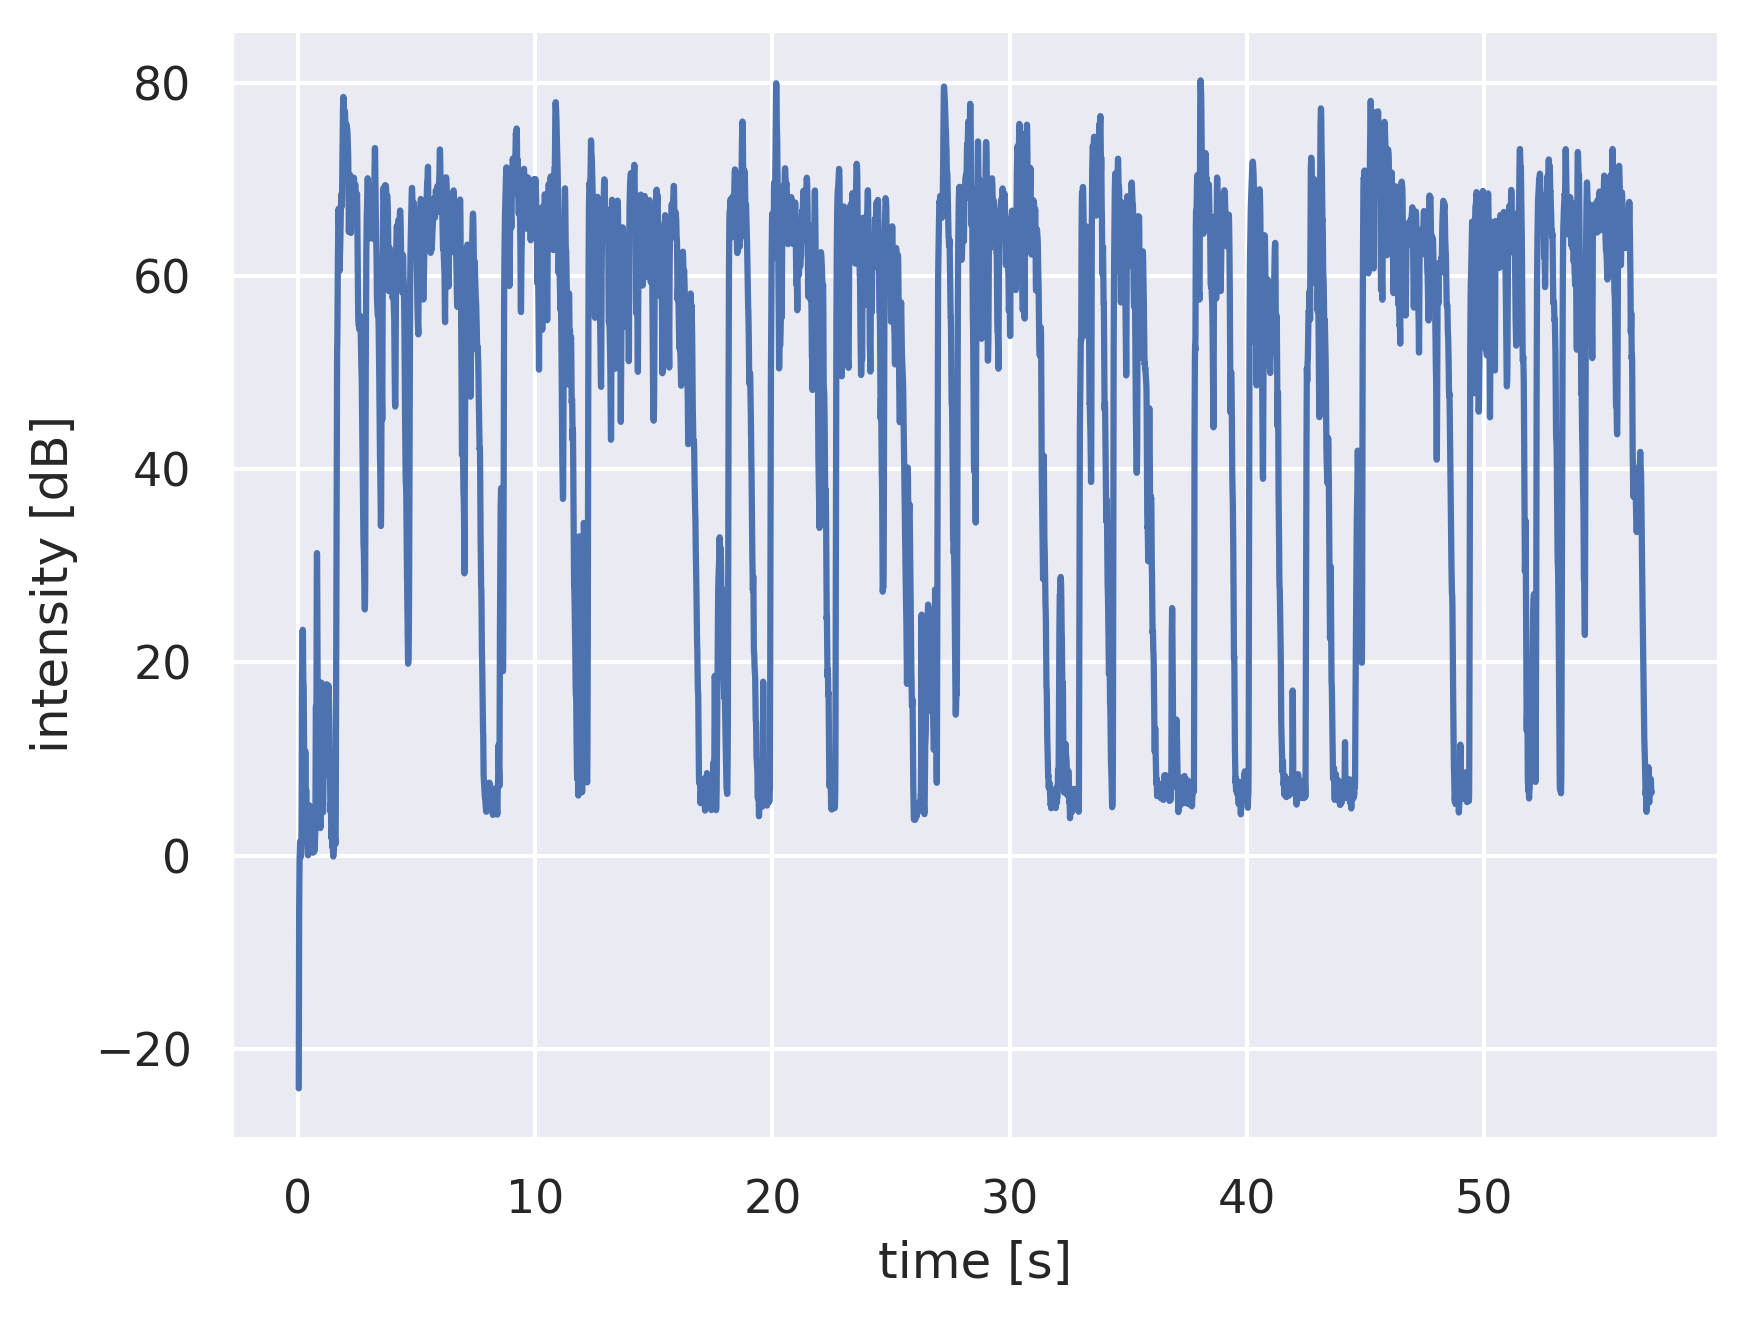

In [10]:
plt.figure()
plt.plot(intensity.xs(), intensity.values.T)
plt.xlabel("time [s]")
plt.ylabel("intensity [dB]")
plt.show() 

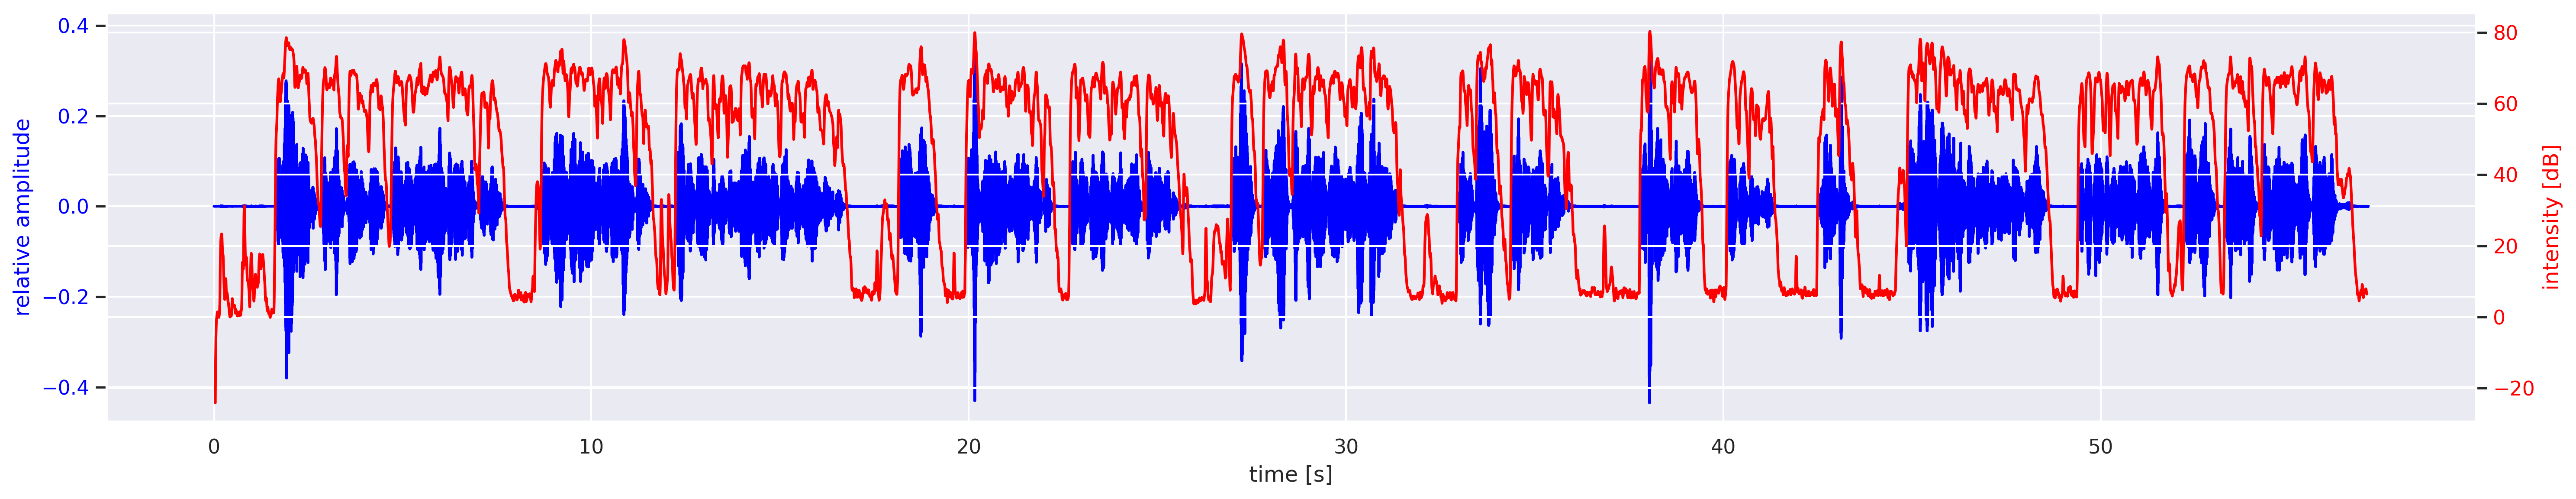

In [11]:
# Assuming snd and intensity are already defined
fig, ax1 = plt.subplots(figsize=(20, 4))

# Plot the amplitude on the first y-axis
ax1.plot(snd.xs(), snd.values.T, color='blue')
ax1.set_xlabel("time [s]")
ax1.set_ylabel("relative amplitude", color='blue')
ax1.tick_params(axis='y', labelcolor='blue')

# Create a second y-axis for the intensity
ax2 = ax1.twinx()
ax2.plot(intensity.xs(), intensity.values.T, color='red')
ax2.set_ylabel("intensity [dB]", color='red')
ax2.tick_params(axis='y', labelcolor='red')

# Show the plot
fig.tight_layout()  # Adjust layout to prevent overlap
plt.show()

## Speech Tempo
The best measure I could find is Words per minute

### Try simple speech recognition for word count

#### Free Google Recognition

In [12]:
import speech_recognition as sr
# Initialize recognizer
recognizer = sr.Recognizer()
# Load the audio file
with sr.AudioFile(audio_filename) as source:
    audio_data = recognizer.record(source)
    # Recognize speech using Google Web Speech API
    text_by_google = recognizer.recognize_google(audio_data, language=audio_filename_language)
    print("Transcription by Google:", text_by_google)

Transcription by Google: había una vez un bosque encantado en el que vivía un duende llamado el león El Rey León un secreto muy especial una puerta mágica que solo se abriría con la risa más sincera durante años había observado a los animales del bosque intentando hacerlos reír para abrir la puerta un día el río decidió probar con el erizo más serio del bosque se acercó a él y le contó este chiste qué se pone Superman antes de salir su perfume el erizo no pudo evitar soltar una risa incontrolable la puerta mágica se abrió de par en par y el río y el erizo entraron en un mundo de maravillas


#### Pocket Shpinx Recognition

In [13]:
sphinx_language_parameter = {\
    "es": (\
    "/workspaces/voice-analysis/dependency/pocketsphinx_language/cmusphinx-es-5.2/cmusphinx-es-5.2/model_parameters/voxforge_es_sphinx.cd_ptm_4000",\
    "/workspaces/voice-analysis/dependency/pocketsphinx_language/es-20k.lm.gz",\
    "/workspaces/voice-analysis/dependency/pocketsphinx_language/es.dict"
    ),
    "en": "en-US"
}

In [14]:
with sr.AudioFile(audio_filename) as source:
    audio_data = recognizer.record(source)
    # Recognize speech using Google Web Speech API
    text_by_sphinx = recognizer.recognize_sphinx(audio_data, sphinx_language_parameter[audio_filename_language])
    print("Transcription by sphinx:", text_by_sphinx)


Transcription by sphinx: había una vez um bosque encantado en el que vivian do en mi llamado el río henry on van ahora se quedó muy especial una puerta mágica antes sólo sea brillar con la risa más in cierta durante años a los sábados animales del poste intentando hacerlo ryan para la puerta un día el río de sitio prueba fui somos sirio y buscar qué hace el cual lidia con todo este chi ste que se algo de silver man antes dejaría su perfume eli su pudo evitar sus dólares encontró la haré la puerta mágica sean le cuarenta bien ion inicio entra lou ru do de maravillas


In [15]:
import wave

duration_seconds = 0
with wave.open(audio_filename, "rb") as wav_file:
    # Get the number of frames in the file
    frames = wav_file.getnframes()
    # Get the frame rate (number of frames per second)
    frame_rate = wav_file.getframerate()
    # Calculate the duration in seconds
    duration_seconds = frames / float(frame_rate)

In [16]:
def get_wpm(text: str, duration_seconds: float) -> float:
    words = text.split()
    word_count = len(words)
    #print(words)
    return (word_count / duration_seconds) * 60
wpm_by_google = get_wpm(text_by_google, duration_seconds)
wpm_by_sphinx = get_wpm(text_by_sphinx, duration_seconds)
print(f"WPM by Google {wpm_by_google}")
print(f"WPM by Sphinx {wpm_by_sphinx}")

WPM by Google 116.657908565423
WPM by Sphinx 112.45401996847083


In [17]:
df_speech_tempo = pd.DataFrame(\
    data = zip(\
        ["google_speech_api", "pocketsphinx"],\
        ["recognizer.recognize_google", "recognizer.recognize_sphinx"],\
        [audio_filename_language, audio_filename_language], \
        [audio_filename_language, sphinx_language_parameter[audio_filename_language]],\
        [text_by_google, text_by_sphinx], \
        [wpm_by_google, wpm_by_sphinx]
        ),\
    columns=\
        ["transcript_provider", "transcript_function", "user_input_language", "provider_language_parameter", "provider_transcript", "provider_wpm" ]
        )
destination_speech_tempo_csv =  get_destination_analysis_filename(analysis_id, audio_filename, "speech_tempo")
# Save csvs
df_speech_tempo.to_csv(destination_speech_tempo_csv, index=False)





In [22]:
from tabulate import tabulate

tabulate(df_speech_tempo, headers='keys', showindex=False, tablefmt="github" )


"| transcript_provider   | transcript_function         | user_input_language   | provider_language_parameter                                                                                                                                                                                                                                                                          | provider_transcript                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                         |   provider_wpm |\n|-----------------------|-------